In [2]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import defaultdict
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from scipy.sparse import lil_matrix
import ast
df = pd.read_csv("data/clean_data/recipes_cleaned.csv")
df.head()

,name_x,nutrition,n_steps,ingredients_y,minutes
0,arriba baked winter squash mexican style,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['winter squash', 'mexican seasoning', 'mixed ...",55
1,a bit different breakfast pizza,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['prepared pizza crust', 'sausage patty', 'egg...",30
2,all in the kitchen chili,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['ground beef', 'yellow onions', 'diced tomato...",130
3,alouette potatoes,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,"['spreadable cheese with garlic and herbs', 'n...",45
4,amish tomato ketchup for canning,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"['tomato juice', 'apple cider vinegar', 'sugar...",190


In [3]:
# Parser la colonne ingredients_y
# Vérifier si c'est une string ou déjà une liste
print(f"\nType de ingredients_y : {type(df['ingredients_y'].iloc[0])}")
print(f"Exemple : {df['ingredients_y'].iloc[0]}")

# Si c'est une string (ex: "['salt', 'pepper']"), parser en liste
if isinstance(df['ingredients_y'].iloc[0], str):
    print("Parsing ingredients_y de string vers list...")
    df['ingredients_y'] = df['ingredients_y'].apply(ast.literal_eval)


Type de ingredients_y : <class 'str'>
Exemple : ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
Parsing ingredients_y de string vers list...


In [4]:
# Construire le vocabulaire d'ingrédients
all_ingredients = []
for ing_list in df['ingredients_y']:
    # Dédupliquer dans chaque recette
    all_ingredients.extend(set(ing_list))

unique_ingredients = sorted(set(all_ingredients))
ingredients_index = {ing: idx for idx, ing in enumerate(unique_ingredients)}
n = len(unique_ingredients)

print(f"  Nombre de recettes : {len(df)}")
print(f"  Ingrédients uniques : {n}")

  Nombre de recettes : 222705
  Ingrédients uniques : 14621


In [5]:
# Vérifier la distribution 
ing_per_recipe = df['ingredients_y'].apply(lambda x: len(set(x)))
print(f"  Ingrédients/recette : min={ing_per_recipe.min()}, "
      f"max={ing_per_recipe.max()}, moyenne={ing_per_recipe.mean():.1f}")

  Ingrédients/recette : min=1, max=43, moyenne=9.1


In [6]:
# Construire matrice binaire recettes × ingrédients
# Cette méthode est la plus robuste
n_recipes = len(df)
X = lil_matrix((n_recipes, n), dtype=bool)

for r, ing_list in enumerate(df['ingredients_y']):
    unique_in_recipe = set(ing_list)  # dédupliquer
    for ing in unique_in_recipe:
        X[r, ingredients_index[ing]] = True

# Convertir en CSR pour calculs efficaces
X = X.tocsr()

print(f"  Matrice X : {X.shape}, densité={X.nnz / (X.shape[0] * X.shape[1]):.4f}")

  Matrice X : (222705, 14621), densité=0.0006


In [7]:
# Calculer fréquences et vérifier cohérence 
deg = np.array(X.sum(axis=0)).flatten()  # somme par colonne = fréquence ingrédient

print(f"\n Fréquences des ingrédients :")
print(f"  Min : {deg.min()}")
print(f"  Max : {deg.max()}")
print(f"  Médiane : {np.median(deg):.0f}")
print(f"  Total : {deg.sum()}")

# Top 10 ingrédients
top10_idx = np.argsort(deg)[-10:][::-1]
print(f"\n Top 10 ingrédients les plus fréquents :")
for idx in top10_idx:
    print(f"  {unique_ingredients[idx]}: {deg[idx]} recettes")



 Fréquences des ingrédients :
  Min : 1
  Max : 83152
  Médiane : 5
  Total : 2028585

 Top 10 ingrédients les plus fréquents :
  salt: 83152 recettes
  butter: 53656 recettes
  sugar: 42544 recettes
  onion: 38174 recettes
  water: 33416 recettes
  eggs: 33226 recettes
  olive oil: 32138 recettes
  flour: 25676 recettes
  garlic cloves: 25147 recettes
  milk: 24854 recettes


In [8]:
# --- ÉTAPE 7 (version rapide avec Cosine Distance) ---
from sklearn.metrics.pairwise import cosine_distances
import time, numpy as np

print("\n Calcul de la matrice de distances Cosine (approximation Jaccard)...")

start = time.time()

X_ingredients = X.T  # ingrédients × recettes
distance_matrix = cosine_distances(X_ingredients)  # beaucoup plus rapide

print(f"  Matrice de distances : {distance_matrix.shape}")
print(f"  Min distance : {distance_matrix.min():.4f}")
print(f"  Max distance : {distance_matrix.max():.4f}")
print(f"  Symétrique : {np.allclose(distance_matrix, distance_matrix.T)}")
print(f" Calcul terminé en {(time.time()-start)/60:.2f} min")

np.save("data/distance_matrix_cosine.npy", distance_matrix)



 Calcul de la matrice de distances Cosine (approximation Jaccard)...
  Matrice de distances : (14621, 14621)
  Min distance : 0.0000
  Max distance : 1.0000
  Symétrique : True
 Calcul terminé en 0.10 min


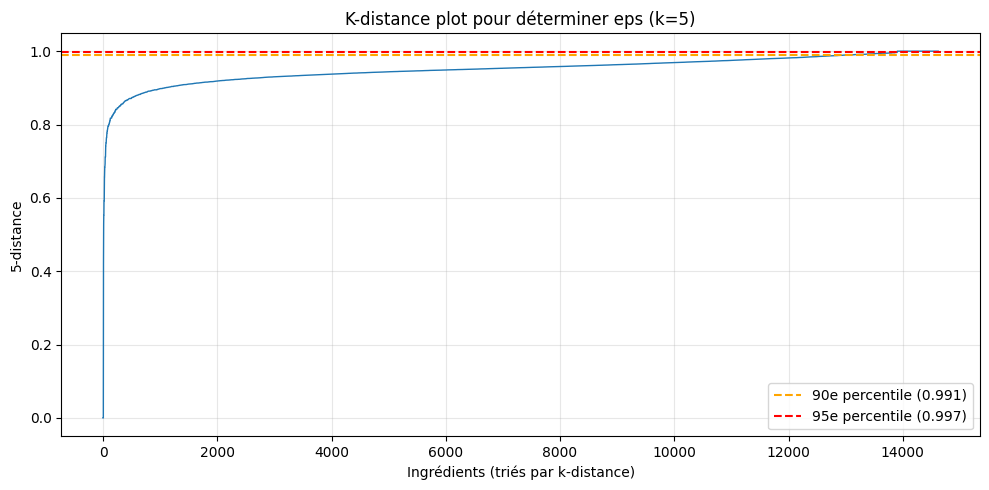


 Suggestions eps :
  90e percentile : 0.991
  95e percentile : 0.997


In [9]:
# Choisir eps via k-distance plot 
from sklearn.neighbors import NearestNeighbors

k = 5  # min_samples
nbrs = NearestNeighbors(n_neighbors=k+1, metric='precomputed').fit(distance_matrix)
distances, indices = nbrs.kneighbors(distance_matrix)
kdist = np.sort(distances[:, k])  # k-ième voisin (exclut soi-même)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(kdist, linewidth=1)
plt.xlabel('Ingrédients (triés par k-distance)')
plt.ylabel(f'{k}-distance')
plt.title(f'K-distance plot pour déterminer eps (k={k})')
plt.grid(True, alpha=0.3)

# Suggérer eps au 90e percentile comme départ
eps_90 = np.percentile(kdist, 90)
eps_95 = np.percentile(kdist, 95)
plt.axhline(y=eps_90, color='orange', linestyle='--', label=f'90e percentile ({eps_90:.3f})')
plt.axhline(y=eps_95, color='red', linestyle='--', label=f'95e percentile ({eps_95:.3f})')
plt.legend()
plt.tight_layout()
plt.savefig('kdistance_plot.png', dpi=150)
plt.show()

print(f"\n Suggestions eps :")
print(f"  90e percentile : {eps_90:.3f}")
print(f"  95e percentile : {eps_95:.3f}")

In [10]:
for eps in [0.5, 0.55, 0.6, 0.65, 0.7, 0.8, 0.85, 0.9, 0.93, 0.95]:
    db = DBSCAN(eps=eps, min_samples=5, metric='precomputed').fit(distance_matrix)
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    noise = np.sum(db.labels_ == -1)
    print(f"eps={eps:.3f} → clusters={n_clusters}, noise={noise}")




eps=0.500 → clusters=6, noise=14587
eps=0.550 → clusters=8, noise=14572
eps=0.600 → clusters=11, noise=14547
eps=0.650 → clusters=19, noise=14504
eps=0.700 → clusters=29, noise=14441
eps=0.800 → clusters=108, noise=13863
eps=0.850 → clusters=195, noise=12740
eps=0.900 → clusters=274, noise=9264
eps=0.930 → clusters=140, noise=4420
eps=0.950 → clusters=25, noise=1316


In [ ]:
from collections import defaultdict

# Exécuter DBSCAN avec le meilleur eps (ex: 0.6)
db = DBSCAN(eps=0.6, min_samples=5, metric='precomputed').fit(distance_matrix)
labels = db.labels_
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"\nClusters found with Cosine (eps=0.6): {n_clusters}")


# Group ingredients by cluster
clusters = defaultdict(list)
for ing, label in zip(vectorizer.get_feature_names_out(), labels):
    clusters[label].append(ing)

# Display a few examples per cluster
for k, v in clusters.items():
    if k == -1:
        print(f"\nNoise ({len(v)} ingrédients isolés):")
    else:
        print(f"\nCluster {k} ({len(v)} ingrédients): {', '.join(v[:10])} ...")



Clusters found with Cosine (eps=0.6): 11


NameError: name 'vectorizer' is not defined